In [25]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from IPython.display import display

# Oxford
`OX_1-1_pouch_LCO_40C_0-100_2-1.84C_a_timeseries`

| Cell ID                                | Anode    | Cathode | Source  | Ah   | Form Factor | Temperature (C) | Max SOC | Min SOC | Charge Rate (C) | Discharge Rate (C) |
|----------------------------------------|----------|---------|---------|------|-------------|-----------------|---------|---------|-----------------|--------------------|
| OX_1-1_pouch_LCO_40C_0-100_2-1.84C_a_timeseries | graphite | LCO     | oxford  | 0.74 | pouch       | 40.00           | 100.00  | 0.00    | 2.00            | 1.84               |

## Limpeza e preparação

- Corrente negativa --> descarga
- Corrente positiva --> carga

In [26]:
# Header: Date_Time,Test_Time (s),Cycle_Index,Current (A),Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh),Environment_Temperature (C),Cell_Temperature (C)
df = pd.read_csv('Battery_Archive_Data/Oxford/OX_1-1_pouch_LCO_40C_0-100_2-1.84C_a_timeseries.csv')

# Apenas features de interesse são mantidas
# Obs: Envoironment_Temperature (C) poderia ser relevante, mas tem todos os valores nulos. Então, é removida
df = df[["Cycle_Index", "Test_Time (s)", "Current (A)", "Voltage (V)", "Discharge_Capacity (Ah)", "Cell_Temperature (C)"]]

# Mantem apenas as linhas em que a bateria está descarregando, ou seja, corrente < 0
df = df[df['Current (A)'] < 0]

# Remove valores para Cell_Temperature < 1 (incorretos)
df = df[df['Cell_Temperature (C)'] >= 1]

display(df)
display(df.describe())

,Cycle_Index,Test_Time (s),Current (A),Voltage (V),Discharge_Capacity (Ah),Cell_Temperature (C)
1,1.0,9.990000e-01,-0.74,4.175,0.000,40.051
2,1.0,1.999000e+00,-0.74,4.174,0.000,39.988
3,1.0,2.999000e+00,-0.74,4.172,0.000,39.976
4,1.0,3.999000e+00,-0.74,4.171,0.000,39.964
5,1.0,4.999000e+00,-0.74,4.170,0.001,39.988
...,...,...,...,...,...,...
457802,8200.0,5.517855e+07,-0.74,3.336,0.528,41.249
457803,8200.0,5.517855e+07,-0.74,3.335,0.528,41.237
457804,8200.0,5.517855e+07,-0.74,3.333,0.528,41.199
457805,8200.0,5.517855e+07,-0.74,3.332,0.529,41.224


,Cycle_Index,Test_Time (s),Current (A),Voltage (V),Discharge_Capacity (Ah),Cell_Temperature (C)
count,227455.000000,2.274550e+05,2.274550e+05,227455.000000,227455.000000,227455.000000
mean,3967.207615,2.669858e+07,-7.400000e-01,3.765557,0.305788,40.523928
std,2444.986810,1.680400e+07,2.220451e-16,0.195065,0.179824,0.470356
min,1.000000,9.990000e-01,-7.400000e-01,2.699000,0.000000,39.614000
25%,1900.000000,1.224665e+07,-7.400000e-01,3.656000,0.151000,40.113000
50%,3900.000000,2.608378e+07,-7.400000e-01,3.759000,0.303000,40.400000
75%,6100.000000,4.162771e+07,-7.400000e-01,3.902000,0.455000,40.912000
max,8200.000000,5.517871e+07,-7.400000e-01,4.176000,0.741000,41.699000


## Visualização

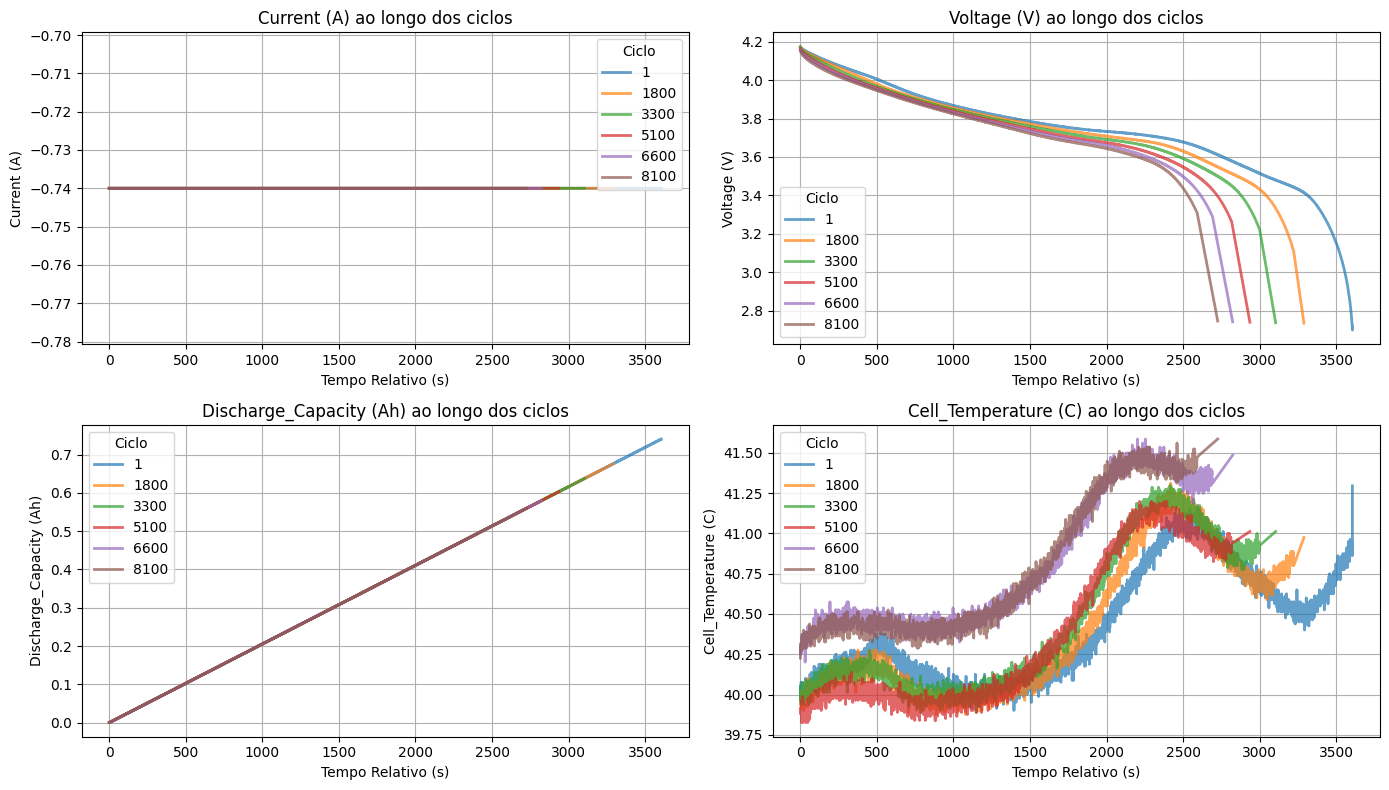

In [27]:
# Lista de features que deseja analisar (exceto "Cycle_Index")
features = ["Current (A)", "Voltage (V)", "Discharge_Capacity (Ah)", "Cell_Temperature (C)"]

# Ciclos únicos e ordenados
cycles = df["Cycle_Index"].unique()
cycles.sort()
NumCyclesPlot = 5

# Seleciona 'NumCyclesPlot' ciclos igualmente espaçados para plotar
if len(cycles) > NumCyclesPlot:
    cycles = cycles[::len(cycles)//NumCyclesPlot] # // --> Divisão inteira

# Cria os subplots com layout 2x2
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.flatten()  # Facilita a iteração

# Itera sobre cada feature e sobre os ciclos para plotar os dados
for i, feature in enumerate(features):
    ax = axs[i]
    for cycle in cycles:
        # Seleciona os dados do ciclo e calcula o tempo relativo
        df_cycle = df[df["Cycle_Index"] == cycle].copy()
        df_cycle['Tempo_Relativo (s)'] = df_cycle["Test_Time (s)"] - df_cycle["Test_Time (s)"].min()
        # Plota a feature em função do tempo relativo
        ax.plot(df_cycle['Tempo_Relativo (s)'], df_cycle[feature], alpha=0.7, label=f'{int(cycle)}', linewidth=2.0)

    ax.set_title(f'{feature} ao longo dos ciclos')
    ax.set_xlabel('Tempo Relativo (s)')
    ax.set_ylabel(feature)
    ax.grid(True)
    ax.legend(title="Ciclo", loc='best')

plt.tight_layout()
plt.show()


## SOH no decorrer dos ciclos

$$
\text{SOH} = \frac{\text{capacidade\_atual}}{\text{capacidade\_inicial}}
$$

- $CapacidadeInicial$ é a capacidade nominal, a maior considerando todo o histórico da bateria
- $CapacidadeAtual$ é a maior capacidade do ciclo

In [28]:
# Capacidade nominal (máxima global)
nominal_capacity = df['Discharge_Capacity (Ah)'].max()
print(f'Capacidade total de descarga: {nominal_capacity} Ah')

# para cada ciclo, extrai a maior capacidade 
# (cycles_capacity é uma série do Pandas)
cycles_capacity = df.groupby('Cycle_Index')['Discharge_Capacity (Ah)'].max()
cycles_capacity = cycles_capacity.reset_index() # transforma em dataframe
cycles_capacity.columns = ['Cycle_Index', 'Max_Discharge_Capacity']
cycles_capacity['SOH_discharge'] = (cycles_capacity['Max_Discharge_Capacity'] / nominal_capacity)
display(cycles_capacity)


Capacidade total de descarga: 0.741 Ah


,Cycle_Index,Max_Discharge_Capacity,SOH_discharge
0,1.0,0.741,1.000000
1,100.0,0.732,0.987854
2,200.0,0.728,0.982456
3,300.0,0.725,0.978408
4,400.0,0.720,0.971660
...,...,...,...
72,7800.0,0.564,0.761134
73,7900.0,0.564,0.761134
74,8000.0,0.563,0.759784
75,8100.0,0.560,0.755735


In [29]:
# Definir os valores de capacidade total
# valor maximo de capacidade de descarga
nominal_capacity = df['Discharge_Capacity (Ah)'].max()
print(f'Capacidade total de descarga: {nominal_capacity} Ah')

df_grouped = df.groupby('Cycle_Index', as_index=False).mean()
df_grouped = df_grouped.drop(columns=['Test_Time (s)'])

# Adição do SOH calculado em ciclos_capacity
df_grouped['SOH_discharge'] = cycles_capacity['SOH_discharge']
df_grouped = df_grouped.drop(columns=['Current (A)', 'Voltage (V)', 'Discharge_Capacity (Ah)'])
df_grouped = df_grouped[['Cycle_Index', 'SOH_discharge', 'Cell_Temperature (C)']]

display(df_grouped)
display(df_grouped.describe())

Capacidade total de descarga: 0.741 Ah


,Cycle_Index,SOH_discharge,Cell_Temperature (C)
0,1.0,1.000000,40.419166
1,100.0,0.987854,40.319742
2,200.0,0.982456,40.317441
3,300.0,0.978408,40.311226
4,400.0,0.971660,40.304815
...,...,...,...
72,7800.0,0.761134,40.733336
73,7900.0,0.761134,40.738304
74,8000.0,0.759784,40.720570
75,8100.0,0.755735,40.774364


,Cycle_Index,SOH_discharge,Cell_Temperature (C)
count,77.000000,77.000000,77.000000
mean,4188.324675,0.847942,40.537653
std,2448.283784,0.069428,0.178534
min,1.000000,0.755735,40.227923
25%,2200.000000,0.788124,40.379861
50%,4200.000000,0.835358,40.470904
75%,6300.000000,0.896086,40.733336
max,8200.000000,1.000000,40.801851


In [ ]:
# supondo que você já tenha:
# df_grouped = pd.DataFrame(drop_cycles).set_index('cycle')  ou equivalente

# 1) Defina os thresholds de interesse (99%, 98%, ...)
thresholds = np.arange(0.99, 0.00, -0.01)

# 2) Para usar np.interp, precisamos de arrays ordenados com x crescente:
#    queremos: ciclo = f⁻¹(SOH), 
#    então xp = SOH em ordem crescente, fp = Cycle_Index correspondente.
soh = df_grouped['SOH_discharge'].values
cycles = df_grouped['Cycle_Index'].values

xp = soh[::-1]       # inverte para que fique crescente
fp = cycles[::-1]

# 3) Faz a interpolação
#    np.interp(x, xp, fp) assume xp crescente e retorna fp para cada x em thresholds
valid = (thresholds >= xp.min()) & (thresholds <= xp.max())
ths = thresholds[valid]
estimated_cycles = np.interp(ths, xp, fp)

# 4) Monta um DataFrame de saída
df_estimates = pd.DataFrame({
    'SOH_threshold': ths,
    'estimated_cycle': estimated_cycles
})

# Number of cycles drop (1%)
df_estimates['NCD1%'] = df_estimates['estimated_cycle'].diff()

# Cast
df_estimates['estimated_cycle'] = df_estimates['estimated_cycle'].astype(int)
df_estimates['SOH_threshold'] = df_estimates['SOH_threshold'].astype(float).round(2)

display(df_estimates)


,SOH_threshold,estimated_cycle,NCD1%
0,0.99,82,NaN
1,0.98,260,178.156667
2,0.97,440,180.333333
3,0.96,652,211.800000
4,0.95,851,198.450000
5,0.94,1082,230.750000
6,0.93,1343,261.500000
7,0.92,1609,265.833333
8,0.91,1856,247.000000
9,0.90,2103,247.000000


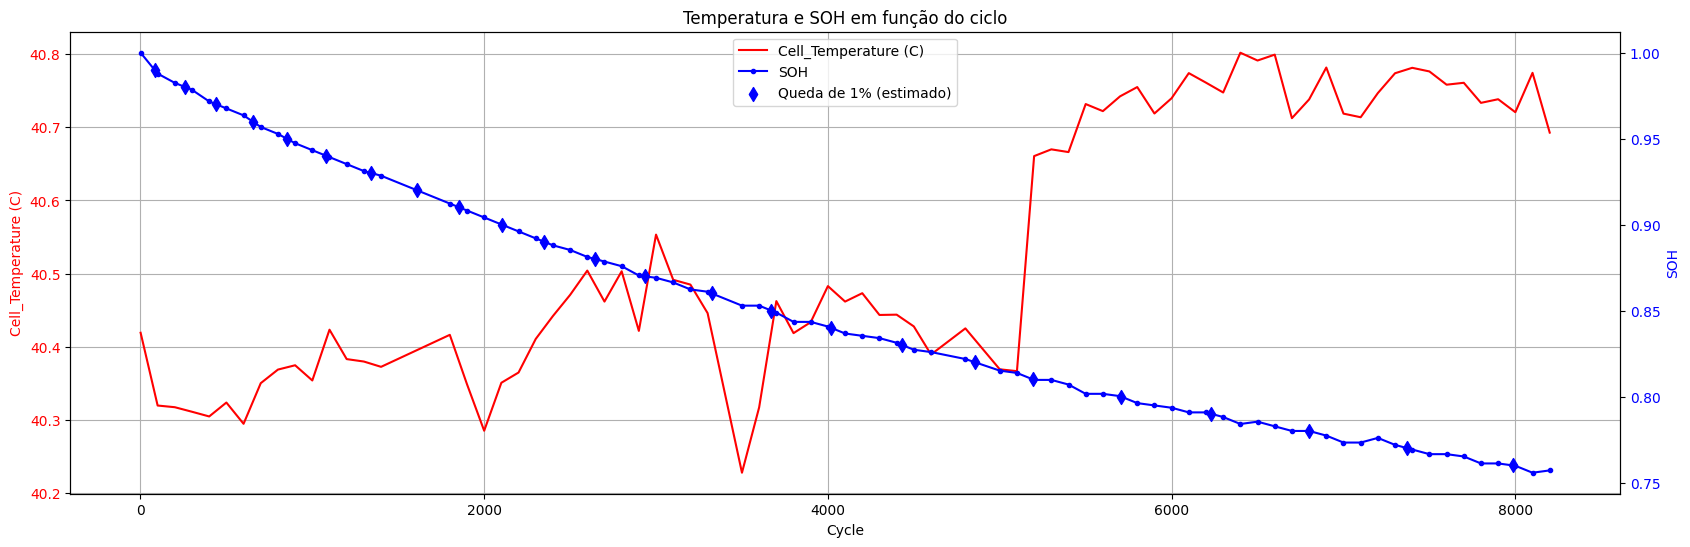

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,6))

# Eixo temperatura
ax1.plot(
    df_grouped["Cycle_Index"],
    df_grouped["Cell_Temperature (C)"],
    label="Cell_Temperature (C)",
    color='red'
)
ax1.set_xlabel("Cycle")
ax1.set_ylabel("Cell_Temperature (C)", color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.grid(True)

# Eixo SOH
ax2 = ax1.twinx()
ax2.plot(
    df_grouped["Cycle_Index"],
    df_grouped["SOH_discharge"],
    label="SOH",
    color='blue',
    marker='.'
)
ax2.set_ylabel("SOH", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax2.scatter(
    df_estimates["estimated_cycle"],
    df_estimates["SOH_threshold"],
    color='blue',
    marker='d',
    s=50,
    label="Queda de 1% (estimado)"
)

plt.title("Temperatura e SOH em função do ciclo")

# Combina as legendas dos dois eixos
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center')

plt.show()


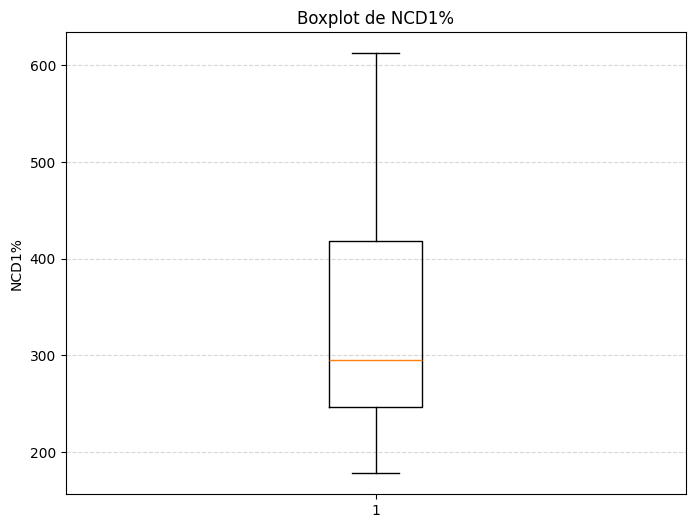

In [44]:
import matplotlib.pyplot as plt

# Seleciona a série, removendo valores nulos
data = df_estimates["NCD1%"].dropna()

# Cria o boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(data)
plt.ylabel("NCD1%")
plt.title("Boxplot de NCD1%")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.show()


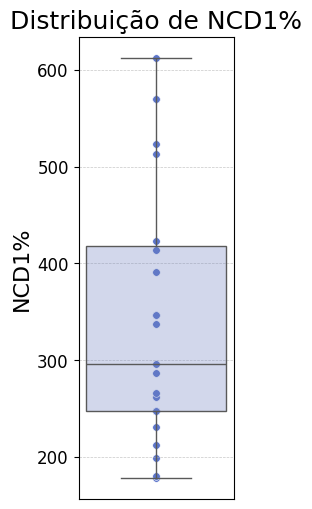

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que df_estimates já está carregado no ambiente
# e contém a coluna "NCD1%".
data = df_estimates["NCD1%"].dropna().values

# Configuração de estética
np.random.seed(4)
colors = list(sns.colors.crayons.values())
rndcolor = np.random.choice(colors)

# Cria figura e eixos
fig, ax = plt.subplots(figsize=(2, 6))

# Boxplot
sns.boxplot(x=np.zeros_like(data), y=data,
            ax=ax,
            linewidth=1,
            fliersize=3,
            color=rndcolor,
            zorder=2)

# Ajusta a facecolor para ficar semitransparente
for patch in ax.patches:
    if hasattr(patch, 'get_facecolor'):
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 0.3))

# Overlay de pontos
sns.scatterplot(x=np.zeros_like(data), y=data,
                ax=ax,
                s=30,
                color=rndcolor,
                zorder=1)

# Remover ticks do eixo x
ax.set_xticks([])

# Labels e títulos
ax.set_ylabel("NCD1%", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.title("Distribuição de NCD1%", fontsize=18)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()


In [ ]:
# Calcula a soma acumulada da coluna SOH_discharge
df_grouped["cum_SOH"] = df_grouped["SOH_discharge"].cumsum()

mean = df_grouped["SOH_discharge"].mean()
std = df_grouped["SOH_discharge"].std()

print("Média dos incrementos:", mean)
print("Desvio Padrão dos incrementos:", std)
display(df_grouped)

Média dos incrementos: 0.8479415321520584
Desvio Padrão dos incrementos: 0.06942751957062439


,Cycle_Index,Current (A),Voltage (V),Discharge_Capacity (Ah),Cell_Temperature (C),SOH_discharge,cum_SOH
0,1.0,-0.74,3.734169,0.370422,40.419166,1.000000,1.000000
1,100.0,-0.74,3.747943,0.360354,40.319742,0.987854,1.987854
2,200.0,-0.74,3.753684,0.355627,40.317441,0.982456,2.970310
3,300.0,-0.74,3.755413,0.353264,40.311226,0.978408,3.948718
4,400.0,-0.74,3.754933,0.351824,40.304815,0.971660,4.920378
...,...,...,...,...,...,...,...
72,7800.0,-0.74,3.772130,0.268272,40.733336,0.761134,62.257760
73,7900.0,-0.74,3.772726,0.266834,40.738304,0.761134,63.018893
74,8000.0,-0.74,3.771303,0.266834,40.720570,0.759784,63.778677
75,8100.0,-0.74,3.772765,0.266113,40.774364,0.755735,64.534413


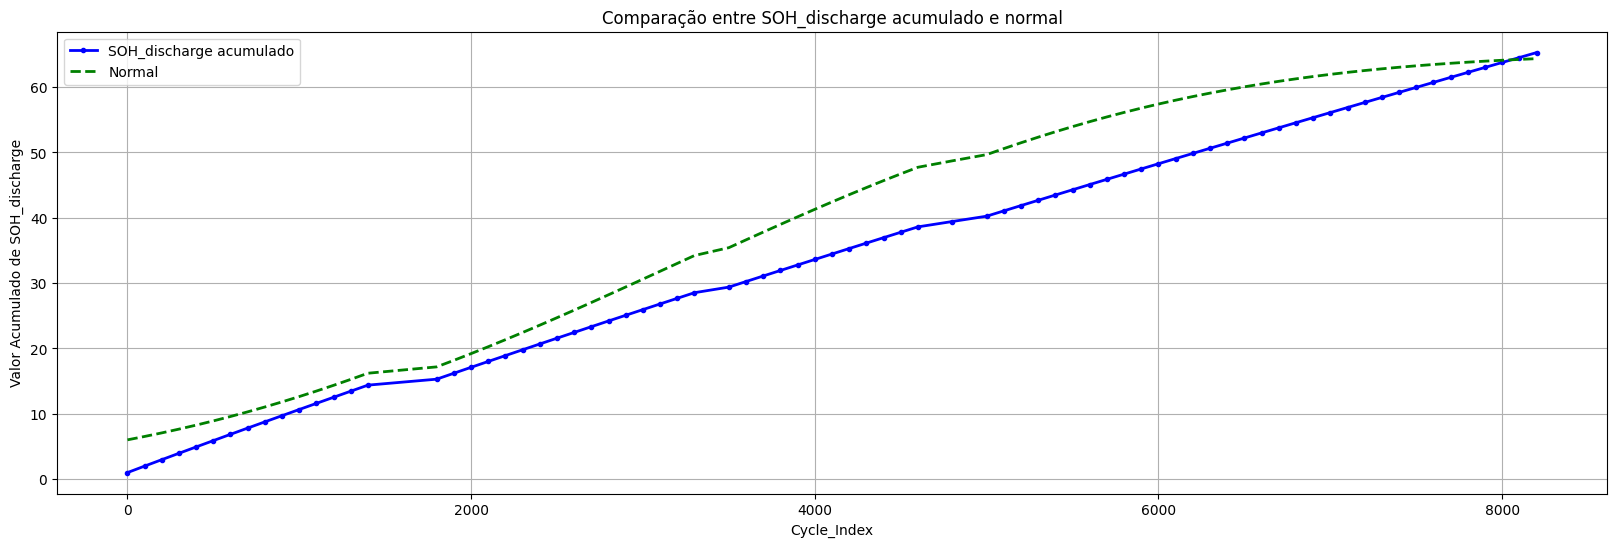

In [15]:
# gera um vetor x nos valores do seu eixo
x = np.linspace(df_grouped["SOH_discharge"].min(), df_grouped["SOH_discharge"].max(), len(df_grouped))

# calcula a CDF da normal nos pontos x
cdf = norm.cdf(x, loc=mean, scale=std)

# agora escala a CDF para o mesmo nível do acumulado real
expected_cumsum = cdf * (df_grouped["cum_SOH"].iloc[-1])

fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(df_grouped["Cycle_Index"], df_grouped["cum_SOH"], label="SOH_discharge acumulado", color="blue", marker='.', linewidth=2)
ax.plot(df_grouped["Cycle_Index"], expected_cumsum, label="Normal", color="green", linestyle="--", linewidth=2)

ax.set_xlabel("Cycle_Index")
ax.set_ylabel("Valor Acumulado de SOH_discharge")
ax.set_title("Comparação entre SOH_discharge acumulado e normal")
ax.legend(loc='best')
ax.grid(True)

plt.show()